# Preparing dataset

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"christopherkeibel","key":"XXX"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# downloading dataset from kaggle
!kaggle competitions download -c dogs-vs-cats

 99% 808M/812M [00:02<00:00, 207MB/s]
100% 812M/812M [00:02<00:00, 290MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("dogs_vs_cats_small")

def make_subset(name:str, start:int, end:int):
    for category in ("dog", "cat"):
        dir = new_base_dir / name / category
        os.makedirs(dir)

        # create list of filename - first all dogs then all cats (category)
        fnames = [f"{category}.{i}.jpg" for i in range(start, end)]

        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

In [7]:
make_subset("train", start=0, end=1_000)
make_subset("validation", start=1_000, end=1_500)
make_subset("test", start=1_500, end=2_500)

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)

val_data = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_data = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# Build model

In [10]:
from tensorflow.keras.applications.vgg16 import  VGG16

# instantiating and freezing conb base
conv_base = VGG16(
    weights="imagenet",
    include_top=False,
)

conv_base.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [11]:
# data augmentation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2)
])

In [13]:
# stacking the model together
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input

inputs = Input(shape=(180, 180, 3))
x = data_augmentation(inputs) # DATA AUGMENTATION
x = preprocess_input(x) # VGG16 value scaling
x = conv_base(x) # VGG16 features
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

In [14]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

MODEL_PATH = "feature_extraction_with_data_augmentation.keras"

callbacks = [
    ModelCheckpoint(
        filepath=MODEL_PATH,
        save_best_only=True,
        monitor="val_loss"
    )
]

In [17]:
res = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=callbacks
)

Epoch 1/50
63/63 [==============================] - 29s 216ms/step - loss: 5.6869 - accuracy: 0.8690 - val_loss: 0.2629 - val_accuracy: 0.9670
Epoch 2/50
63/63 [==============================] - 12s 185ms/step - loss: 0.5004 - accuracy: 0.9380 - val_loss: 0.1592 - val_accuracy: 0.9690
Epoch 3/50
63/63 [==============================] - 12s 187ms/step - loss: 0.3291 - accuracy: 0.9460 - val_loss: 0.2056 - val_accuracy: 0.9700
Epoch 4/50
63/63 [==============================] - 12s 185ms/step - loss: 0.3575 - accuracy: 0.9525 - val_loss: 0.1719 - val_accuracy: 0.9760
Epoch 5/50
63/63 [==============================] - 11s 179ms/step - loss: 0.3737 - accuracy: 0.9530 - val_loss: 0.2367 - val_accuracy: 0.9720
Epoch 6/50
63/63 [==============================] - 12s 179ms/step - loss: 0.2280 - accuracy: 0.9640 - val_loss: 0.3199 - val_accuracy: 0.9700
Epoch 7/50
63/63 [==============================] - 12s 183ms/step - loss: 0.2933 - accuracy: 0.9670 - val_loss: 0.2857 - val_accuracy: 0.9760

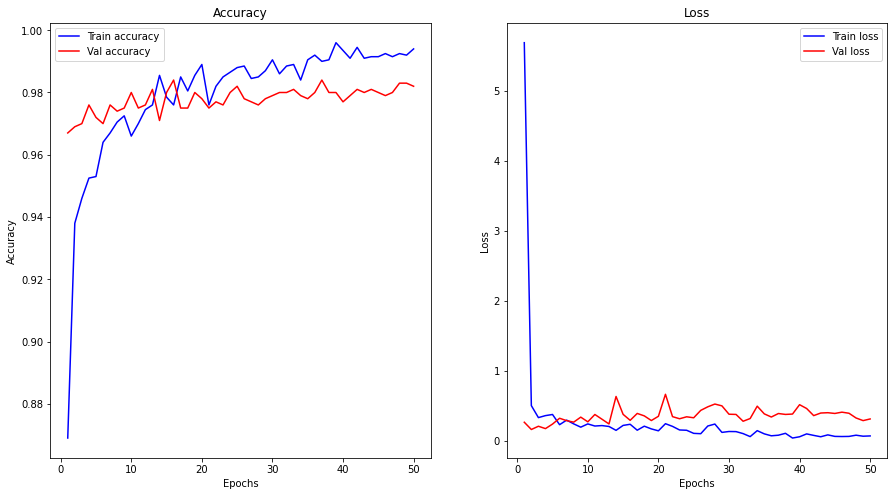

In [23]:
import matplotlib.pyplot as plt

loss = res.history["loss"]
acc = res.history["accuracy"]
val_loss = res.history["val_loss"]
val_acc = res.history["val_accuracy"]

x_range = range(1, len(loss) +1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.plot(x_range, acc, "b", label="Train accuracy")
ax1.plot(x_range, val_acc, "r", label="Val accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy")
ax1.legend()
ax2.plot(x_range, loss, "b", label="Train loss")
ax2.plot(x_range, val_loss, "r", label="Val loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss")
ax2.legend()
plt.show()

In [24]:
from tensorflow.keras.models import load_model

test_model = load_model(MODEL_PATH)
test_loss, test_acc = test_model.evaluate(test_data)

print(f"Test accuracy: {test_acc}")

63/63 [==============================] - 8s 112ms/step - loss: 0.2154 - accuracy: 0.9715
Test accuracy: 0.9714999794960022
